# Hypothesis testing

## La hipótesis nula y la hipótesis alternativa

Uno de los más importantes métodos en la estadística inferencial es el contraste de hipótesis o hypothesis testing. En el contraste de hipótesis, nosotros intentamos determinar si una cierta hipótesis o cuestión es cierta o no, y en que grado.

El objetivo del contraste de hipótesis es responder a la pregunta: *Dada una muestra y un efecto aparente, ¿Cuál es la probabilidad de ver tal efecto por azar?*
The goal of classical hypothesis testing is to answer the question, “Given a sample and
an apparent effect, what is the probability of seeing such an effect by chance?” Here’s
how we answer that question:

1. El primer paso es cuantificar el tamaño del *efecto aparente* eligiendo un test estadístico.
2. Definimos la hipótesis nula, la cual es un modelo del sistema que asume que el efecto aparente no es real.
3. Calculamos el valor **p**, el cual es la probabilidad de ver el efecto si la hipótesis nula es cierta.
4. Interpretamos los resultados. Si el valor **p** es bajo, el efecto es estadísticamente significante, lo cual significa que tal efecto no ocurre por azar. En el caso de inferir el efecto es más probable que aparezca en una muestra mayor.

 $H_{0}$: Hipótesis nula 

 $H_{1}$: Hipótesis alternativa

La hipótesis nula es el valor histórico o valor promedio, mientras que la hipótesis alternativa es aquella que contradice a la hipótesis nula, es decir, aquella que queremos probar si es verdadera o falsa.

Por ejemplo:

La edad promedio en Barcelona es inferior a 38 años (hipótesis nula), pero realizando un muestreo, nuestro valor promedio es 42 años. Entonces la pregunta sería si la edad promedio en la ciudad de Barcelona a aumentado o si por el contrario nuestro valor promedio es erróneo. Este es un ejemplo de contraste unilateral.

### Contraste bilateral
$$
H_{0} : \mu = \mu_{0} \\
H_{1} : \mu \neq \mu_{0}
$$

### Contraste unilateral

$$
H_{0}: \mu \leq \mu_{0} \\
H_{1}: \mu > \mu_{0}
$$
$$
H_{0}: \mu \geq \mu_{0} \\
H_{1}: \mu < \mu_{0}
$$

A continuación vamos a importar las bibliotecas y funciones necesarias para seguir la explicación

In [1]:
# import libraries
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt

# set seaborn style
sns.set()

In [2]:
"""Funciones especiales"""

# Importamos la biblioteca necesaria para enlazar con el archivo requerido
import sys
sys.path.insert(0, '../statistics')

# importamos la función que necesitamos
#from DataManipulation import SampleRows
from reading_data import SampleRows, open_file, splitting
from functions import ecdf
from functions_corr import cov, correlation

# semilla
np.random.seed(0)

## Ejemplo de contraste de hipótesis

En el siguiente ejemplo tenemos los datos procedentes de una estación meteorológica situada en la ciudad de Sheffield. Queremos comparar los datos de lluvia de los meses de Julio y Noviembre, y comprobar si tienen distribuciones de lluvia semejantes. Para ello haremos:

* Permutaciones de los datos y un gráfico donde podremos ver las distintas permutaciones.
* Calcularemos el **valor-p** para corroborar el gráfico.

In [3]:
# data
df_0 = open_file('data/sheffield_weather_station.csv', sep=" ", skiprows=8)
df_0.to_csv('Weather.csv', sep=',')
df_0.head(10)

El data set tiene 1602 filas y 7 columnas


,af,mm,rain,sun,tmax,tmin,yyyy
0,6,1,122.1,---,6.3,1.7,1883
1,2,2,69.8,---,8.0,2.8,1883
2,23,3,29.6,---,4.8,-1.6,1883
3,2,4,74.0,---,12.2,3.8,1883
4,0,5,31.2,---,14.7,6.2,1883
5,0,6,66.2,---,17.7,9.3,1883
6,0,7,77.6,---,18.8,10.5,1883
7,0,8,32.5,---,19.8,10.9,1883
8,0,9,137.4,---,16.8,10.0,1883
9,0,10,102.9,---,12.7,6.4,1883


In [4]:
# Analizamos el data set
df_0.describe()

,af,mm,rain,sun,tmax,tmin,yyyy
count,1602,1602,1602,1602,1602,1602,1602
unique,29,12,926,831,222,167,134
top,0,3,57.2,---,---,3.4,1963
freq,872,134,6,553,24,25,12


In [5]:
# tipos del data set
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1602 entries, 0 to 1601
Data columns (total 7 columns):
af      1602 non-null object
mm      1602 non-null object
rain    1602 non-null object
sun     1602 non-null object
tmax    1602 non-null object
tmin    1602 non-null object
yyyy    1602 non-null object
dtypes: object(7)
memory usage: 87.7+ KB


In [6]:
# extraemos las lluvias de julio
rain_july = df_0[df_0.loc[:,'mm'] == '7']['rain'].values

# filtramos los datos
rain_july = np.array(list(filter(lambda x: x != "---", rain_july)))

# convertimos a entero
rain_july = np.array(list(map(float, rain_july)))

# extraemos las lluvias de noviembre
rain_november = df_0[df_0.loc[:,'mm'] == '10']['rain'].values

# filtramos los datos
rain_november = np.array(list(filter(lambda x: x != "---", rain_november)))

# convertimos a entero
rain_november = np.array(list(map(float, rain_november)))

# info
print("Noviembre: ", rain_november.shape)
print("Julio: ", rain_july.shape)

Noviembre:  (133,)
Julio:  (133,)


Una vez hemos obtenido los datos podemos trabajar con ellos.

Vamos a suponer, *hipótesis nula*, que los datos de lluvia de los meses julio y noviembre, están distribuidos de la misma forma, es decir, proceden de la misma distribución con la misma probabilidad.

Para ello lo que haremos será juntar todos los datos, ya que suponemos que provienen de la misma distribución no nos importa mezclarlos, y posteriormente volveremos a separar los datos mezclados y desordenados. Una vez hecho esto, realizaremos cada uno de los gráficos de cada permutación.

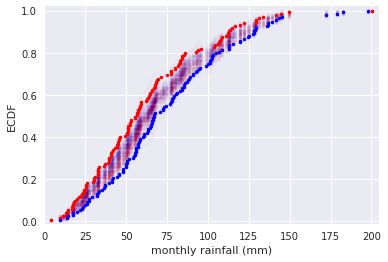

In [7]:
# Generate permutation samples
data_0 = np.r_[rain_july, rain_november]


for _ in range(50):
    perm_data = np.random.permutation(data_0)

    perm_sample_1 = perm_data[len(rain_july):]
    perm_sample_2 = perm_data[:len(rain_november)]


    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    plt.plot(x_1, y_1, marker='.', linestyle='none', color='red', alpha=0.02)
    plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue', alpha=0.02)

# Create and plot ECDFs from original data
x_1, y_1 = ecdf(rain_july)
x_2, y_2 = ecdf(rain_november)
plt.plot(x_1, y_1, marker='.', linestyle='none', color='red')
plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue')

# Label axes, set margin, and show plot
plt.margins(0.02)
plt.xlabel('monthly rainfall (mm)')
plt.ylabel('ECDF')
plt.show()

Podemos observar que las muestras permutadas se superponen. Ninguna de las funciones de distribución acumulada sobrepasa los datos observados, esto nos sugiere que la **hipótesis** no es conmensurable con los datos, por lo tanto julio y noviembre tienen diferentes distribuciones de lluvia. Es decir, rechazamos la **hipótesis nula** y nos quedamos con la **hipótesis alternativa**

Pero pongamos todo esto en números. Vamos a calcular el **valor-p**, que nos dará una probabilidad de que la hipótesis nula sea cierta.

### Valor-p

Si las distribuciones de lluvia son parecidas para julio y noviembre, la diferencia entre sus medias debería de ser cero. Podemos realizar distintas permutaciones como hemos hecho anteriormente, con los datos de lluvia mezclados, y utilizarlos para calcular las medias de todas las permutaciones que hagamos. Posteriormente compararemos dicha media con la media *real*.

In [8]:
# diferencias entre las medias de los dos conjuntos
diff_med = np.abs(np.mean(rain_july) - np.mean(rain_november))

# realizamos n = 10.000 permutaciones
reps = 10000
perm_mean = np.empty(reps)

for i in range(reps):
    perm_data = np.random.permutation(data_0)

    perm_sample_1 = perm_data[len(rain_july):]
    perm_sample_2 = perm_data[:len(rain_november)]
    
    # calculamos la media
    perm_mean[i] = np.abs(np.mean(perm_sample_1) - np.mean(perm_sample_2))

# comprobamos los valores por encima de la media
p = np.sum(perm_mean >= diff_med) / reps

print("Valor p: ", p)

Valor p:  0.003


#### Resultados

Muy pocos valores, de los obtenidos en las distintas permutaciones, han resultado ser mayores que la diferencia de la media real. Estos valores procedían de la suposición (hipótesis) de que las distribuciones de las lluvias eran idénticas, por tanto no importaba de donde coger los datos, ya que estos estaban igualmente distribuidos. El resultado es que solo un 0.2% de los valores aceptan la **hipótesis nula**, por lo que esta es rechazada. Las distribuciones de lluvia en julio y en agosto son diferentes.

### Distribución nula

Es la distribución de los datos según la hipótesis nula.

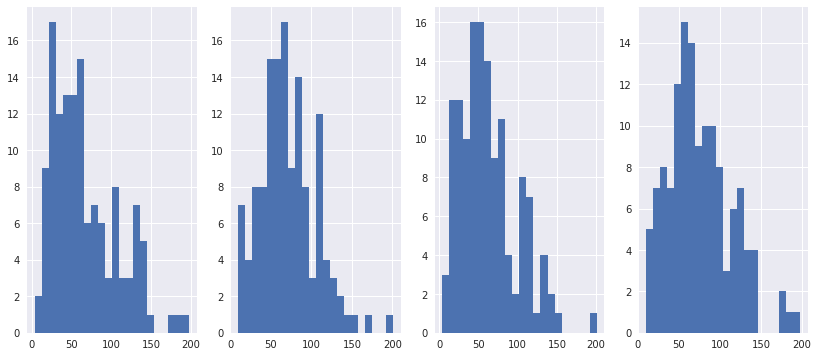

In [9]:
plt.figure(figsize=(14,6))

plt.subplot(1,4,1)
plt.hist(perm_sample_1, bins=2*int(np.sqrt(len(perm_sample_1))))

plt.subplot(1,4,2)
plt.hist(perm_sample_2, bins=2*int(np.sqrt(len(perm_sample_2))))

plt.subplot(1,4,3)
plt.hist(rain_july, bins=2*int(np.sqrt(len(rain_july))))

plt.subplot(1,4,4)
plt.hist(rain_november, bins=2*int(np.sqrt(len(rain_november))))

plt.show()

## Hipótesis test para el coeficiente de correlación

En el siguiente ejemplo veremos que lo anteriormente explicado su puede aplicar a cualquier estadístico, para ello vamos a utilizar el coeficiente de correlación de Pearson $\rho$

In [10]:
# Data
df_1 = pd.read_csv('data/female_literacy_fertility.csv', header=0, index_col=0)
df_1.head(10)

,Continent,female literacy,fertility,population
Country,,,,
Chine,ASI,90.5,1.769,"1,324,655,000"
Inde,ASI,50.8,2.682,"1,139,964,932"
USA,NAM,99.0,2.077,"304,060,000"
Indonésie,ASI,88.8,2.132,"227,345,082"
Brésil,LAT,90.2,1.827,"191,971,506"
Pakistan,ASI,40.0,3.872,"166,111,487"
Bangladesh,ASI,49.8,2.288,"160,000,128"
Nigéria,AF,48.8,5.173,"151,212,254"
Fédération de Russie,EUR,99.4,1.393,"141,950,000"


In [11]:
# añadimos una columna que será la invera de alfabetismo
df_1['female illiteracy'] = 1 - df_1['female literacy']

Analizamos la posible correlación entre dos variables. En este caso hemos elegido un *dataset* en el cual existen dos variables interesantes: **fertilidad** y **analfabetismo**. A continuación vamos a realizar un análisis exploratorio de estas variables. Como podemos observar, los datos no nos dan el índice de analfabetismo sino el índice de alfabetización en cada país. Para obtener el índice de analfabetismo simplemente realizamos una *inversión* o diferencia.

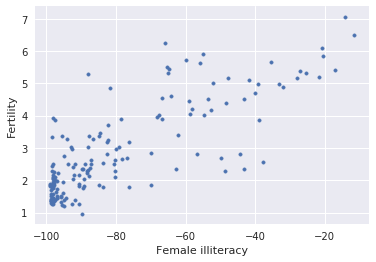

In [12]:
# Exploratory analysis of female literacy and fertility
plt.scatter(df_1['female illiteracy'], df_1['fertility'], marker='.')
plt.xlabel('Female illiteracy')
plt.ylabel('Fertility')
plt.show()

Vemos una posible correlación entre analfabetismo y fertilidad, pero esta correlación podría deberse al azar. Aquí podemos formular nuestras hipótesis:

* **Hipótesis nula**: no hay correlación entre analfabetismo y fertilidad, por lo tanto no importa como estén distribuidos los datos de analfabetismo.
* **Hipótesis alternativa**: si hay una correlación entre las dos variables, y si desordenamos el conjunto de datos de analfabetismo no conseguiremos obtener un coeficiente de correlacion $\rho$ igual o mayor que el obtenido.

Vamos a proceder a calcular el valor obtenido del conjunto de datos. Posteriormente desordenaremos el conjunto de datos de analfabetismo y calcularemos $\rho$ cada vez que hagamos este proceso. Por último compararemos los valores con el obtenido, y lo dividiremos entre el número total de entradas para obtener la probabilidad.

In [13]:
# variables
illiteracy = df_1['female illiteracy'].values
fertility = df_1['fertility'].values

# calculamos el coeficiente de correlación
r_obs = np.corrcoef(illiteracy, fertility)[0][1]

# Initialize permutation replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute illiteracy measurments: illiteracy_permuted
    illiteracy_permuted = np.random.permutation(illiteracy)

    # Compute Pearson correlation
    perm_replicates[i] = np.corrcoef(illiteracy_permuted, fertility)[0][1]

# Compute p-value: p
p = np.sum(perm_replicates >= r_obs) / len(perm_replicates)
print('p-val =', p)

p-val = 0.0


Hemos obtenido un **valor-p** de cero. Esto significa que nuestro valor-p es muy bajo, tanto que no hemos obtenido ni un solo valor igual o mayor que el obtenido del conjunto de datos original. Esto hace que rechacemos la **hipótesis nula** y nos quedemos con la alternativa que suponía que las variables estaban correlacionadas.

## Z test

### SE ( standard error)

El error estándar es una medida de lo lejos que esperamos que esté la estimación, en promedio. Por cada simulación, calculamos el error, x̄ - μ , y entonces calculamos la raíz cuadrada de la media del error (RMSE, root mean square error).

Mientras, el **intervalo de confianza** es, un rango que incluye una fracción dada de la distribución del muestreo. Por ejemplo, el intervalo de confianza del 90% es el rango del 5º al 95º percentil

La gente a menudo confunde el error estándar con la desviación estándar. Recuerde que la desviación estándar describe la variabilidad en una cantidad medida, mientras que el error estándar describe la variabilidad en una estimación. Cuando el número de elemento de la muestra aumenta, el error estándar disminuye, en cambio la desviación estándar no.



Supongamos que se nos presenta el caso en el que tenemos una variable de la cual conocemos la media y la desviación estándar. Dado otro conjunto de datos perteneciente a la misma variable anterior, se nos presenta el caso en el cual la media obtenida difere de la media conocida.

Vamos a suponer que *Just Eat* afirma que nos puede traer una pizza en un tiempo *promedio* inferior a 20 minutos con una desviación típica de 3 minutos.

$$
\mu_{0} = 20 \\
\sigma_{0} = 3
$$

Como sospechamos que es falso, tomamos 64 de las entregas de la última semana y obtenemos una media de 21.4 minutos de media.
¿Podemos aceptar su afirmación a un nivel de confianza del 95%?
Si el resultado es estadísticamente significativo, podríamos afirmar que la media anterior es ahora errónea, y la nueva media se ajusta mejor a la realidad. ¿Por que puede ocurrir esto? Por ejemplo la distribución de edades de una ciudad puede variar en el tiempo y la media de edad irá evolucionando.

En nuestro ejemplo hay que considerar varias cosas:

* puede que el pizzero se haya apoyado en unos datos que están desfasados o están falseados, y por eso la media que nosotros hemos medido es diferente a la media obtenida por el pizzero.

* Nuestros datos pueden tener sesgos de algún tipo, y por eso la media es errónea. Será estadísticamente significativa pero estará ceñida a las restricciones de la población de muestra.

$$
n = 64 \\
\mu = 21.2 \\
\alpha = 0.05
$$

In [16]:
def zvalue(mu, mu0, sigma, size):
    """
    Calcula el estadístico Z o Z valor.
    """
    return (mu - mu0) / (sigma / ( np.sqrt(size)))

In [22]:
# Distribución teórica del tiempo
distrib_tiemp = 20 + 3 * np.random.randn(64)

# valor z obtenido
z_ob = zvalue(21.2, 20, 3, 64)

# valor z teórico
z_exp = ss.zscore(distrib_tiemp)

# resultados
print("Valor Z obtenido: ", z_ob)
print("Valor Z teórico: ", z_exp)

Valor Z obtenido:  3.199999999999998
Valor Z teórico:  [-1.68310624 -0.43098813 -1.25632087  0.72331205  0.14185916  2.17665313
  0.69554642 -2.14808313  0.33072519  0.18996569 -0.74271036  0.3064264
  0.28724581 -1.77712148 -0.42938965  1.5731523  -0.33256552 -0.36868963
  0.30949435 -0.52944003  0.08769758  0.70501035 -0.57875604  1.23805908
  1.31612501  0.76493383  0.86126243 -1.37702403  0.73120333  1.65518984
 -0.7317982  -0.39252933  0.97831128  0.63956606  1.11943874  0.14316088
 -0.67156079  0.16269616  0.41912881 -1.20424951  0.72060486 -0.12226342
 -0.88658954 -1.56775711  2.65159661 -1.36336449  1.37588783  1.04792821
  0.13586767 -1.92747368 -0.20015756 -0.80459707 -1.41625225 -0.14690661
 -0.29008698 -0.74986018 -0.35929057 -0.59140451 -0.10270602  1.39992906
  0.05056763 -0.35681934  0.58512521  0.01619131]
